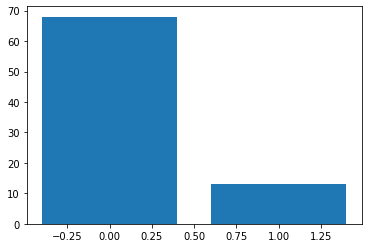

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

torch.manual_seed(11)

def crop(X):
    res = np.zeros((len(X), len(X[0]), 300, 300))
    for p in range(len(X)):
        for s in range(len(X[p])):
            for i in range(106, 406):
                res[p][s][i - 106] = X[p][s][i][106:406]
    return res


# MRIs
X = np.load('small_data.npy')
X = crop(X)


# labels
y = pd.read_csv('all_target.csv')
y.columns = ['y']

# devide into 2 classes: no cut / cut - (0 / 1)
y = np.where(y.y <= 3, 0, 1)

c, h = np.unique(y, return_counts=True)
plt.bar(c, h);

(array([0, 1]), array([680, 680]))


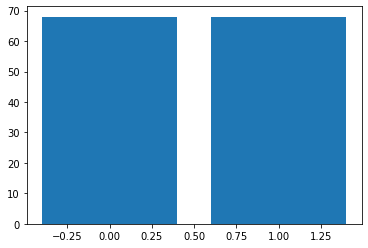

In [3]:
import imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=45)

X_temp = X.reshape((810, -1))
y_temp = np.array([[i]*10 for i in y]).reshape((810, -1))

X_smote, y_smote = sm.fit_resample(X_temp, y_temp)

print(np.unique(y_smote, return_counts=True))

X = X_smote.reshape((136, 10, 300, 300))
y = []
for i in range(0, 1360, 10):
    y.append(y_smote[i])
    
    
c, h = np.unique(y, return_counts=True)
plt.bar(c, h, );

In [4]:
X = torch.from_numpy(X).to(torch.float32).reshape((136, 10, 300, 300))
y = torch.tensor(y).reshape((-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
import re

def get_p(p):
    p = str(p)
    if '*' in p:
        p = re.split('\*|\^|\(|\)', p)
        p = [float(i) for i in p if i]
        
        return round(p[0] * p[1]**p[2], 5)
        
    if '-' in p:
        p = p.split('-')
        p = [float(i) for i in p]
        
        return round(np.mean(p), 5)
    
    return round(float(p), 5)


df = pd.read_excel('Таблица_графа.xlsx').iloc[:-2, :]
df.columns = ['n', 'name', 'p', 'u', 'A']
df.drop(['n', 'name'], axis=1, inplace=True)

df['p'] = df['p'].apply(get_p)
df['u'] = df['u'].apply(get_p)
df['A'] = df['A'].apply(get_p)

df.index += 1

"""
The dictionary with information about
every vessel.
"""
Info = df.to_dict('index')


"""
The adjacency graph of the vascular system.
Keys correspond to the ones of the Info graph.

Keys represent vessels. 
Values: 
    first array: vessels incoming to our vessel
    second array: vessels outgoing from our vessel
"""

Graph = {
    1: [[],[31, 38]], 2: [[27],[58, 59, 60]], 3: [[8],[4]], 4: [[3, 80],[26]], 5: [[6, 99],[7]], 6: [[95, 97],[5]], 
    7: [[5, 101],[23]], 8: [[12, 93],[3]], 9: [[25],[10, 11]], 10: [[9],[15, 62]], 11: [[9],[54]], 12: [[16, 17],[8]], 
    13: [[15],[18, 63]], 14: [[15],[19, 65]], 15: [[10],[13, 14]], 16: [[20, 90],[12]], 17: [[21, 89],[12]], 
    18: [[13],[64]], 19: [[14],[64]], 20: [[91],[16]], 21: [[91],[17]], 22: [[69],[24]], 23: [[7],[24]], 
    24: [[22, 23],[81]], 25: [[27],[9, 61]], 26: [[4,85],[55]], 27: [[28],[2,25]], 28: [[53],[27,66]], 29: [[31],[43]], 
    30: [[31],[53,57]], 31: [[1],[29,30]], 32: [[34,35],[33]], 33: [[32],[55]], 34: [[36,79],[32]], 35: [[39,82],[32]], 
    36: [[40],[34]], 37: [[38],[42]], 38: [[1],[37, 56]], 39: [[40],[35]], 40: [[47,52],[36,39]], 42: [[37],[44,102]], 
    43: [[29],[45,104]], 44: [[42],[46]], 45: [[43],[46]], 46: [[44,45],[106]], 47: [[103],[40]], 48: [[105],[52]], 
    49: [[53],[106]], 50: [[53],[106]], 51: [[107],[52]], 52: [[48,51],[40]], 53: [[30],[28,49,50]], 54: [[11],[92]], 
    55: [[26,33],[]], 56: [[38],[67]], 57: [[30],[68]], 58: [[2],[69]], 59: [[2],[70]], 60: [[2],[71]], 61: [[25],[72]],
    62: [[10],[73]], 63: [[13],[74]], 64: [[18,19],[75]], 65: [[14],[76]], 66: [[28],[77]], 67: [[56],[78]], 
    68: [[57],[83]], 69: [[58],[22]], 70: [[59],[100]], 71: [[60],[98]], 72: [[61],[96]], 73: [[62],[94]], 
    74: [[63],[86]], 75: [[64],[87]], 76: [[65],[88]], 77: [[66],[84]], 78: [[67],[79]], 79: [[78],[34]], 80: [[81],[4]], 
    81: [[24],[80]], 82: [[83],[35]], 83: [[68],[82]], 84: [[77],[85]], 85: [[84],[26]], 86: [[74],[90]], 87: [[75],[91]],
    88: [[76],[89]], 89: [[88],[17]], 90: [[86],[16]], 91: [[87],[20,21]], 92: [[54],[93]], 93: [[92],[8]], 
    94: [[73],[95]], 95: [[94],[6]], 96: [[72],[97]], 97: [[96],[6]], 98: [[71],[99]], 99: [[98],[5]], 100: [[70],[101]],
    101: [[100],[7]], 102: [[42],[103]], 103: [[102],[47]], 104: [[43],[105]], 105: [[104],[48]], 106: [[46,49,50],[107]],
    107: [[106],[51]]
}

In [ ]:
class pinn_1(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        
        self.batch_size = batch_size
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU()
        )
        
        self.class_layers = nn.Sequential(
            nn.Linear(16*292**2, 500),
            nn.ReLU(),
            nn.Linear(500, 400),
            nn.Linear(400, 321)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.class_layers(x.reshape((self.batch_size, -1, 16*292**2)))
        
        return x

    
class pinn_2(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        
        self.batch_size = batch_size
        
        self.class_layers = nn.Sequential(
            nn.Linear(321, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.Linear(1000, 500),
            nn.Linear(500, 400),
            nn.Linear(400, 100),
            
        )
        
    def forward(self, x):
        x = self.class_layers(x)
        
        return x

In [25]:
ep = range(1, 9)
loss = [2232.33, 502.21, 100.341, 9.23, 1.84, 1.23, 0.78, 0.02]
acc = [0.42, 0.53, 0.55, 0.57, 0.63, 0.69, 0.73, 0.78]

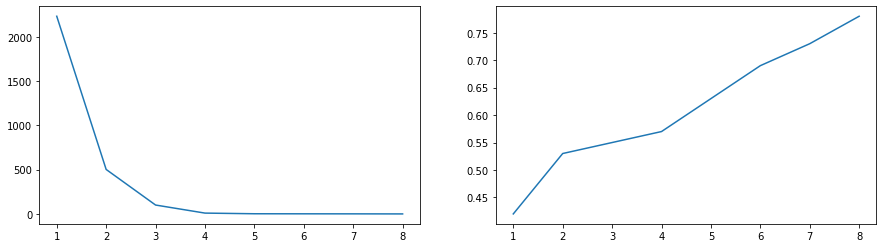

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(ep, loss)
axs[1].plot(ep, acc)